In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import skimage.io as io
import numpy as np
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Data paths
base_path = os.path.join('..', '..', 'data', 'Gauss_S1.00_NL0.30_B0.00')

# Load data
def load_images(base_path, num_images):
    emcal_list, hcal_list, trkn_list, trkp_list, truth_list = [], [], [], [], []
    for i in range(num_images):
        emcal = io.imread(os.path.join(base_path, f'emcal_{i}.tiff'))
        hcal = io.imread(os.path.join(base_path, f'hcal_{i}.tiff'))
        trkn = io.imread(os.path.join(base_path, f'trkn_{i}.tiff'))
        trkp = io.imread(os.path.join(base_path, f'trkp_{i}.tiff'))
        truth = io.imread(os.path.join(base_path, f'truth_{i}.tiff'))

        emcal_list.append(emcal)
        hcal_list.append(hcal)
        trkn_list.append(trkn)
        trkp_list.append(trkp)
        truth_list.append(truth)

    return emcal_list, hcal_list, trkn_list, trkp_list, truth_list

emcal_list, hcal_list, trkn_list, trkp_list, truth_list = load_images(base_path, 10000)



Using device: cuda


In [3]:
emcal_list = np.array(emcal_list)
hcal_list = np.array(hcal_list)
trkp_list = np.array(trkp_list)
trkn_list = np.array(trkn_list)
truth_list = np.array(truth_list)

X = np.array(list(zip(trkp_list,trkn_list,emcal_list,hcal_list)))

y = np.array(truth_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size = 100, shuffle = False)

test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size = 100, shuffle = False)

In [4]:


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, stride=1, padding=1),  # 32*56*56
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # 32*56*56
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32*28*28

        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64*28*28
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 64*28*28
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64*14*14

        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 128*14*14
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # 128*14*14
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128*7*7

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 256*7*7
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # 256*7*7
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  
        self.decoder3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  
        self.decoder2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  
        self.decoder1 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Final output layer
        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)  

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc1_pool = self.pool1(enc1)
        enc2 = self.encoder2(enc1_pool)
        enc2_pool = self.pool2(enc2)
        enc3 = self.encoder3(enc2_pool)
        enc3_pool = self.pool3(enc3)

        bottleneck = self.bottleneck(enc3_pool)

        dec3_up = self.upconv3(bottleneck)
        dec3 = self.decoder3(torch.cat([dec3_up, enc3], dim=1))
        dec2_up = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat([dec2_up, enc2], dim=1))
        dec1_up = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat([dec1_up, enc1], dim=1))

        output = self.final_conv(dec1)
        return output

learning_rate = 0.001
epochs = 250

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
unet_model = UNet().to(device)
loss_func = nn.MSELoss().to(device)
optimizer = optim.Adam(unet_model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

unet_model.train()
for epoch in range(epochs):
    for count, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = target.view(data.size(0), 1, 56, 56)  # Ensure target shape is correct

        optimizer.zero_grad()
        output = unet_model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()

    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Saving the model
torch.save(unet_model.state_dict(), 'unet_model.pth')

Epoch 1/250, Loss: 0.06358829140663147
Epoch 2/250, Loss: 0.04156789183616638
Epoch 3/250, Loss: 0.03350389376282692
Epoch 4/250, Loss: 0.029178721830248833
Epoch 5/250, Loss: 0.02645890787243843
Epoch 6/250, Loss: 0.024516161531209946
Epoch 7/250, Loss: 0.02291363663971424
Epoch 8/250, Loss: 0.021309852600097656
Epoch 9/250, Loss: 0.01975368894636631
Epoch 10/250, Loss: 0.01845606602728367
Epoch 11/250, Loss: 0.01736227236688137
Epoch 12/250, Loss: 0.01647854782640934
Epoch 13/250, Loss: 0.015735112130641937
Epoch 14/250, Loss: 0.015024739317595959
Epoch 15/250, Loss: 0.014428899623453617
Epoch 16/250, Loss: 0.0139229167252779
Epoch 17/250, Loss: 0.013434065505862236
Epoch 18/250, Loss: 0.012976019643247128
Epoch 19/250, Loss: 0.012507995590567589
Epoch 20/250, Loss: 0.012072055600583553
Epoch 21/250, Loss: 0.011772275902330875
Epoch 22/250, Loss: 0.011413762345910072
Epoch 23/250, Loss: 0.011045834049582481
Epoch 24/250, Loss: 0.010531521402299404
Epoch 25/250, Loss: 0.01007068902254

In [5]:
Rms = lambda x : np.sqrt(np.mean(x**2))

In [6]:
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)

unet_model.eval()
y_pred_list = []
y_test_list = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        outputs = unet_model(data)
        y_pred_list.append(outputs.cpu().numpy())
        y_test_list.append(target.cpu().numpy())

y_pred = np.concatenate(y_pred_list)
y_test_numpy = np.concatenate(y_test_list)
print(f'Model Score: {np.corrcoef(y_test_numpy.flatten(), y_pred.flatten())[0, 1]:.9f}')

# Check GPU power usage
if device.type == 'cuda':
    import subprocess
    gpu_power_usage = subprocess.check_output(
        ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits']
    ).decode('utf-8').strip()

Model Score: 0.998117914


In [7]:
y_pred.resize(3300,56,56)
print(y_pred.shape)
print(y_test_numpy.shape)


(3300, 56, 56)
(3300, 56, 56)


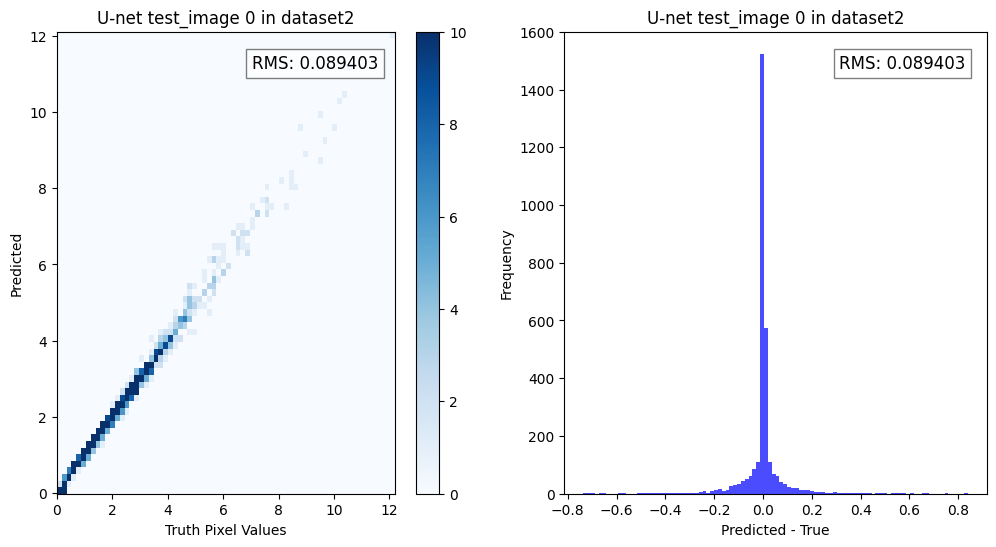

In [11]:
def image_plot(image_index):
    true_data = np.array(y_test_numpy[image_index,:,:]).flatten()
    predicted_data = np.array(y_pred[image_index,:,:]).flatten()

    error_2d = predicted_data - true_data

    rms_2d = np.sqrt(np.mean(error_2d**2))

    # 绘制2D直方图（保留 true_data=0 的情况）
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist2d(true_data, predicted_data, bins=(70, 70), cmap='Blues', vmin=0, vmax=10)
    plt.colorbar()
    plt.title(f'U-net test_image {image_index} in dataset2')
    plt.xlabel('Truth Pixel Values')
    plt.ylabel('Predicted')
    plt.text(0.95, 0.95, f'RMS: {rms_2d:.6f}', horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))


    # 计算 RMS 值（1D）
    rms_1d = rms_2d

    # 绘制1D直方图（去掉 true_data=0 的情况）
    plt.subplot(1, 2, 2)
    plt.hist(error_2d, bins=100, color='blue', alpha=0.7)
    plt.title(f'U-net test_image {image_index} in dataset2')
    plt.xlabel('Predicted - True')
    plt.ylabel('Frequency')

    # 在图表上添加RMS值
    plt.text(0.95, 0.95, f'RMS: {rms_1d:.6f}', horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()
image_plot(0)

In [9]:
sum=0
for image_index in range(500):
    true_data = np.array(y_test_numpy[image_index,:,:]).flatten()
    predicted_data = np.array(y_pred[image_index,:,:]).flatten()
    error_2d = predicted_data - true_data

    rms_2d = np.sqrt(np.mean(error_2d**2))
    sum+=rms_2d
print(sum/500)
    

0.09864566983282566
